In [1]:
import pyspark as ps
from pyspark.sql.types import *
from pyspark.sql.functions import struct, col, when, lit
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16, 'font.family': 'sans'})
import numpy as np
import scipy.stats as stats

plt.style.use('ggplot')

In [2]:
def scatter_plt(ax, x, y, title, xlab, ylab, color, zorder=1):
    '''Create a scatter plot

    Parameters
    ----------
    ax: plot axis
    x: list in the x-axis
    y: list in the y-axis
    title: str
    xlab: str
    ylab: str
    color: str
    zorder: int, default set to 1

    Returns
    -------
    None
    '''
    ax.scatter(x, y, alpha= 0.5, color=color, s=50, zorder=1)
    ax.set_title(title, fontsize=35)
    ax.set_ylabel(xlab, fontsize=20)
    ax.set_xlabel(ylab, fontsize=20)
    

In [3]:
def line_plt(ax, x, y, color, label):
    '''Create a line plot

    Parameters
    ----------
    ax: plot axis
    x: list in the x-axis
    y: list in the y-axis
    label: str
    color: str

    Returns
    -------
    None
    '''
    ax.plot(x, y, linewidth=2, color=color, label=label )


In [4]:
def drop_na_column(df, lst):
    '''Removes rows with null or n/a values from a dataframe

    Parameters
    ----------
    df: dataframe in sparks
    lst: list of strings
    
    Returns
    -------
    returns a dataframe
    '''
    return df.na.drop(subset=lst)


In [5]:
def bar_plot(ax, data, label):
    '''Create a bar plot

    Parameters
    ----------
    ax: plot axis
    data: list of ints
    label: string
    Returns
    -------
    None
    '''
    ax.bar(label, data, label=label)
    

In [6]:
def fix_fluid_types(df, lst1, lst2):
    '''Renames the fluid types in a dataframe with the correct fluid type

    Parameters
    ----------
    df: dataframe in sparks
    lst1: list of strings
    lst2: list of strings
    
    Returns
    -------
    returns a dataframe
    '''    
    
    
    for i in range(1,6):
        df = df.na.replace(wrong_fluid, right_fluid, 'fluid_type'+str(i))
    return df


In [7]:
def fill_fluid_na(df):
    '''Replaces null or na in a column wiht blank or 0

    Parameters
    ----------
    df: dataframe in sparks
    
    Returns
    -------
    returns a dataframe 
    ''' 
    for i in range(1,6):
        df = df.na.fill({'fluid_type'+str(i): ''})
        df = df.na.fill({'FluidVol'+str(i): 0})
    
    return df


In [8]:
def winner_counter(arr1, arr2):
    '''Compares 2 arrays and keeps count of a win

    Parameters
    ----------
    arr1: np.array
    arr2: np.array
    
    Returns
    -------
    returns int of sum of wins
    ''' 
    arr1, arr2 = np.array(arr1), np.array(arr2)
    win_total = 0
    for x in arr1:
        small_win = np.sum(x > arr2) + 0.5*np.sum(x == arr2)
        win_total += small_win
    return win_total

In [ ]:
def clean_fluid_type(df, fluid_sys):
    '''Passed in dataframe and strings of fluid systems and sums up the volumes
       across all the fluid types

    Parameters
    ----------
    df: dataframe
    fluid_sys: string name of fluid system
    
    Returns
    -------
    returns df
    '''
    
    fluid_vol = 'FluidVol'
    fluid_type = 'fluid_type'
    lowcase_fluid = fluid_sys.lower() + "_collect"
    
    df = df.withColumn(lowcase_fluid, lit(0))
    for i in range(1, 6):
        df = df.withColumn(fluid_sys.lower()+str(i), when(col(fluid_type+str(i)) == fluid_sys, col(fluid_vol+str(i))).otherwise(0))
        df = df.withColumn(lowcase_fluid, col(lowcase_fluid) + col(fluid_sys.lower()+str(i)))

    return df


In [9]:
spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("sparkSQL exercise") 
        .getOrCreate()
        )
sc = spark.sparkContext

In [10]:
df = spark.read.csv('./data/dj_basin.csv',
                         header=True,
                         quote='"',
                         sep=",",
                         inferSchema=True)

In [11]:
df.printSchema()
print(df.count())

root
 |--   : string (nullable = true)
 |-- Formation: string (nullable = true)
 |-- SubFormation: string (nullable = true)
 |-- API: long (nullable = true)
 |-- TenDigitAPI: long (nullable = true)
 |-- WellName: string (nullable = true)
 |-- Operator: string (nullable = true)
 |-- HistoricOperator: string (nullable = true)
 |-- LeaseName: string (nullable = true)
 |-- County: string (nullable = true)
 |-- Section: integer (nullable = true)
 |-- Township: integer (nullable = true)
 |-- TownshipDirection: string (nullable = true)
 |-- Range: integer (nullable = true)
 |-- RangeDirection: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- OilGas: string (nullable = true)
 |-- IpTestDate: string (nullable = true)
 |-- IpOil: integer (nullable = true)
 |-- IpMCF: integer (nullable = true)
 |-- IpWtr: integer (nullable = true)
 |-- IpCondensate: integer (nullable = true)
 |-- IpWC: integer (null

In [12]:
df.createOrReplaceTempView("data")

niobrara_df = spark.sql("""
                    SELECT 
                        api,
                        state,
                        UPPER(formation) AS formation, 
                        Prod180DayOil AS day180,
                        Prod365DayOil AS day365,
                        Prod545DayOil AS day545,
                        Prod730DayOil AS day730,
                        Prod1095DayOil AS day1095,
                        Prod1460DayOil AS day1460,
                        Prod1825DayOil AS day1825,
                        TotalProppant
                    FROM data
                    WHERE state = "COLORADO" AND formation = 'NIOBRARA'
                    ORDER BY day180 DESC
                    """)
niobrara_df = drop_na_column(niobrara_df, ["TotalProppant"])
niobrara_df.show()
col_names = niobrara_df.schema.names


+-------------+--------+---------+------+------+------+------+-------+-------+-------+-------------+
|          api|   state|formation|day180|day365|day545|day730|day1095|day1460|day1825|TotalProppant|
+-------------+--------+---------+------+------+------+------+-------+-------+-------+-------------+
|5123445240000|COLORADO| NIOBRARA|170137|299194|364908|404653|   null|   null|   null|     29152250|
|5123421400000|COLORADO| NIOBRARA|168211|258083|302184|331733| 371447|   null|   null|     27496277|
|5123419900000|COLORADO| NIOBRARA|166440|276840|294349|295169| 296052|   null|   null|     23258909|
|5123469710000|COLORADO| NIOBRARA|163544|223855|  null|  null|   null|   null|   null|     19307299|
|5014207790000|COLORADO| NIOBRARA|162817|  null|  null|  null|   null|   null|   null|     15202030|
|5123419910100|COLORADO| NIOBRARA|162152|272722|324970|367584| 418096|   null|   null|     27444010|
|5123428910000|COLORADO| NIOBRARA|161401|230305|269258|295592|   null|   null|   null|     

In [13]:
col_names = niobrara_df.schema.names

day180_df = drop_na_column(niobrara_df,col_names[3])
y_axis = list()
day = day180_df.rdd.map(lambda y: y.day180).collect()
well_180 = np.median(day)
y_axis.append(well_180)

day365_df = drop_na_column(niobrara_df, col_names[3:5])
day = day365_df.rdd.map(lambda y: y.day365).collect()
well_365 = np.median(day)
y_axis.append(well_365)

day545_df = drop_na_column(niobrara_df, col_names[3:6])

day = day545_df.rdd.map(lambda y: y.day545).collect()
well_545 = np.median(day)
y_axis.append(well_545)

day730_df = drop_na_column(niobrara_df, col_names[3:7])

day = day730_df.rdd.map(lambda y: y.day730).collect()
well_730 = np.median(day)
y_axis.append(well_730)

day1095_df = drop_na_column(niobrara_df, col_names[3:8])

day = day1095_df.rdd.map(lambda y: y.day1095).collect()
well_1095 = np.median(day)
y_axis.append(well_1095)

day1460_df = drop_na_column(niobrara_df, col_names[3:9])

day = day1460_df.rdd.map(lambda y: y.day1460).collect()
well_1460 = np.median(day)
y_axis.append(well_1460)

day1825_df = drop_na_column(niobrara_df, col_names[3:10])

day = day1825_df.rdd.map(lambda y: y.day1825).collect()
well_1825 = np.median(day)
y_axis.append(well_1825)

In [14]:
codell_df = spark.sql("""
                    SELECT 
                        api,
                        state,
                        UPPER(formation) AS formation, 
                        Prod180DayOil AS day180,
                        Prod365DayOil AS day365,
                        Prod545DayOil AS day545,
                        Prod730DayOil AS day730,
                        Prod1095DayOil AS day1095,
                        Prod1460DayOil AS day1460,
                        Prod1825DayOil AS day1825,
                        TotalProppant
                    FROM data
                    WHERE state = "COLORADO" AND formation = 'CODELL'
                    ORDER BY day180 DESC
                    """)
codell_df = drop_na_column(codell_df, ["TotalProppant"])
codell_df.show()

+-------------+--------+---------+------+------+------+------+-------+-------+-------+-------------+
|          api|   state|formation|day180|day365|day545|day730|day1095|day1460|day1825|TotalProppant|
+-------------+--------+---------+------+------+------+------+-------+-------+-------+-------------+
|5123432500000|COLORADO|   CODELL|168677|292043|319381|356587| 434958|   null|   null|     19613850|
|5069064670000|COLORADO|   CODELL|167095|264374|326252|374903|   null|   null|   null|     20100410|
|5001103450000|COLORADO|   CODELL|156658|  null|  null|  null|   null|   null|   null|     14268046|
|5069064680000|COLORADO|   CODELL|154461|247601|294135|334573|   null|   null|   null|     20101350|
|5123444710000|COLORADO|   CODELL|148740|276703|352274|405327|   null|   null|   null|     29616188|
|5123477220000|COLORADO|   CODELL|147122|  null|  null|  null|   null|   null|   null|      5770100|
|5123449690000|COLORADO|   CODELL|142165|293085|415193|466572|   null|   null|   null|     

In [15]:
day180_df = drop_na_column(codell_df, col_names[3])
y_axis_c = list()
day = day180_df.rdd.map(lambda y: y.day180).collect()
well_180 = np.median(day)
y_axis_c.append(well_180)

day365_df = drop_na_column(codell_df, col_names[3:5])
day = day365_df.rdd.map(lambda y: y.day365).collect()
well_365 = np.median(day)
y_axis_c.append(well_365)

day545_df = drop_na_column(codell_df, col_names[3:6])
day = day545_df.rdd.map(lambda y: y.day545).collect()
well_545 = np.median(day)
y_axis_c.append(well_545)

day730_df = drop_na_column(codell_df, col_names[3:7])
day = day730_df.rdd.map(lambda y: y.day730).collect()
well_730 = np.median(day)
y_axis_c.append(well_730)

day1095_df = drop_na_column(codell_df, col_names[3:8])
day = day1095_df.rdd.map(lambda y: y.day1095).collect()
well_1095 = np.median(day)
y_axis_c.append(well_1095)

day1460_df = drop_na_column(codell_df, col_names[3:9])
day = day1460_df.rdd.map(lambda y: y.day1460).collect()
well_1460 = np.median(day)
y_axis_c.append(well_1460)


day1825_df = drop_na_column(codell_df, col_names[3:10])
day = day1825_df.rdd.map(lambda y: y.day1825).collect()
well_1825 = np.median(day)
y_axis_c.append(well_1825)

In [16]:
nio_prop = niobrara_df.rdd.map(lambda x: x.TotalProppant).collect()
cod_prop = codell_df.rdd.map(lambda x: x.TotalProppant).collect()

nio_prop = np.array(nio_prop)/10**6
cod_prop = np.array(cod_prop)/10**6

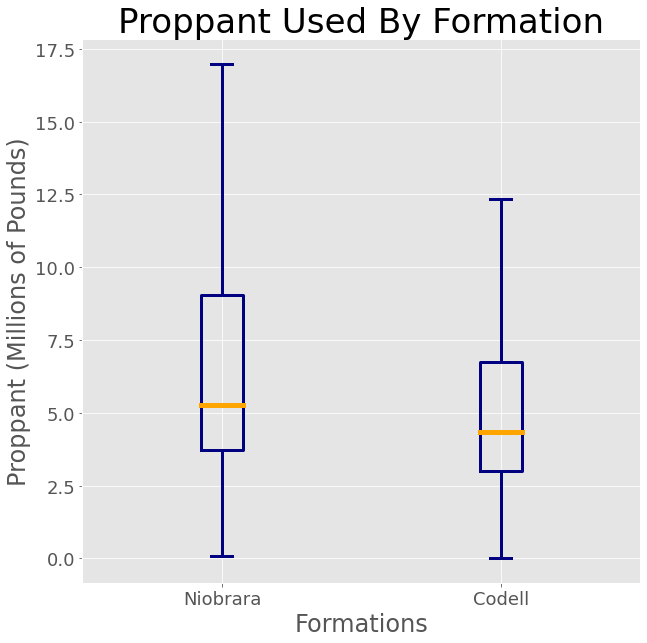

In [17]:
x_labels = ['Niobrara', 'Codell']

fig, ax = plt.subplots(figsize = (10, 10))

ax.boxplot([nio_prop, cod_prop], 
            showfliers=False, 
            medianprops=dict(color="orange", lw=5), 
            boxprops=dict(color='navy', lw=3),
            capprops=dict(color='navy', lw=3),
            whiskerprops=dict(color='navy', lw=3))

ax.set_xticklabels(x_labels);
ax.set_title('Proppant Used By Formation', fontsize=34)
ax.set_xlabel('Formations', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylabel('Proppant (Millions of Pounds)', fontsize=24)

plt.savefig('./images/formation_proppant.png')

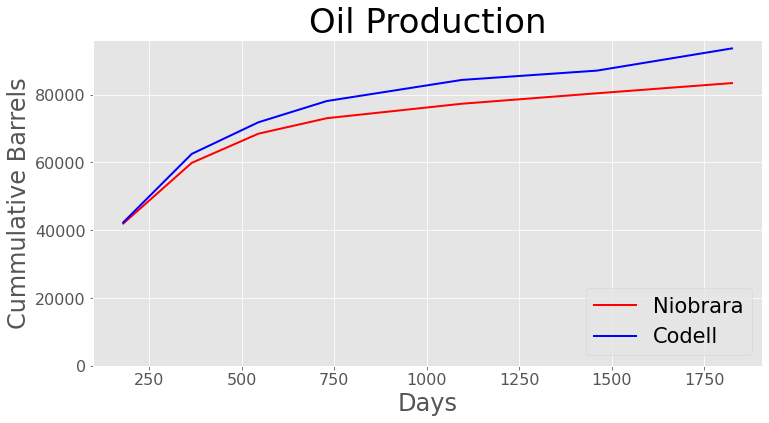

In [18]:
fig, ax = plt.subplots(figsize = (12, 6))
x_axis = [180, 365, 545, 730, 1095, 1460, 1825]

line_plt(ax, x_axis, y_axis, 'red', 'Niobrara')
line_plt(ax, x_axis, y_axis_c, 'blue', 'Codell')

ax.set_title('Oil Production', fontsize=34)
ax.set_xlabel('Days', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel('Cummulative Barrels', fontsize=24)
ax.legend(loc='lower right', fontsize=21)
ax.set_ylim(0)

plt.savefig('images/production_formation.png')

In [19]:
coorid_df = spark.sql("""
                    SELECT 
                        api,
                        State,
                        Latitude, 
                        Longitude
                    FROM data
                    WHERE State = 'COLORADO'
                    """)

In [20]:
coorid_df = coorid_df.na.replace({104.8865041: -104.8865041})
coorid_df = drop_na_column(coorid_df, ["Latitude", "Longitude"])

latitude = coorid_df.rdd.map(lambda y: y.Latitude).collect()
longitude = coorid_df.rdd.map(lambda x: x.Longitude).collect()

x_lat = np.array(latitude)
y_long = np.array(longitude)

bbox = ((min(y_long), max(y_long),      
         min(x_lat), max(x_lat)))

map_ = plt.imread('./images/map_clear.png')


 ax.scatter(y_long, x_lat, zorder=1, alpha= 0.5, color='blue', s=10)
 ax.set_title('Colorado Well Locations', fontsize=35)
 ax.set_ylabel('Latitude', fontsize=20)
 ax.set_xlabel('Longitude', fontsize=20)

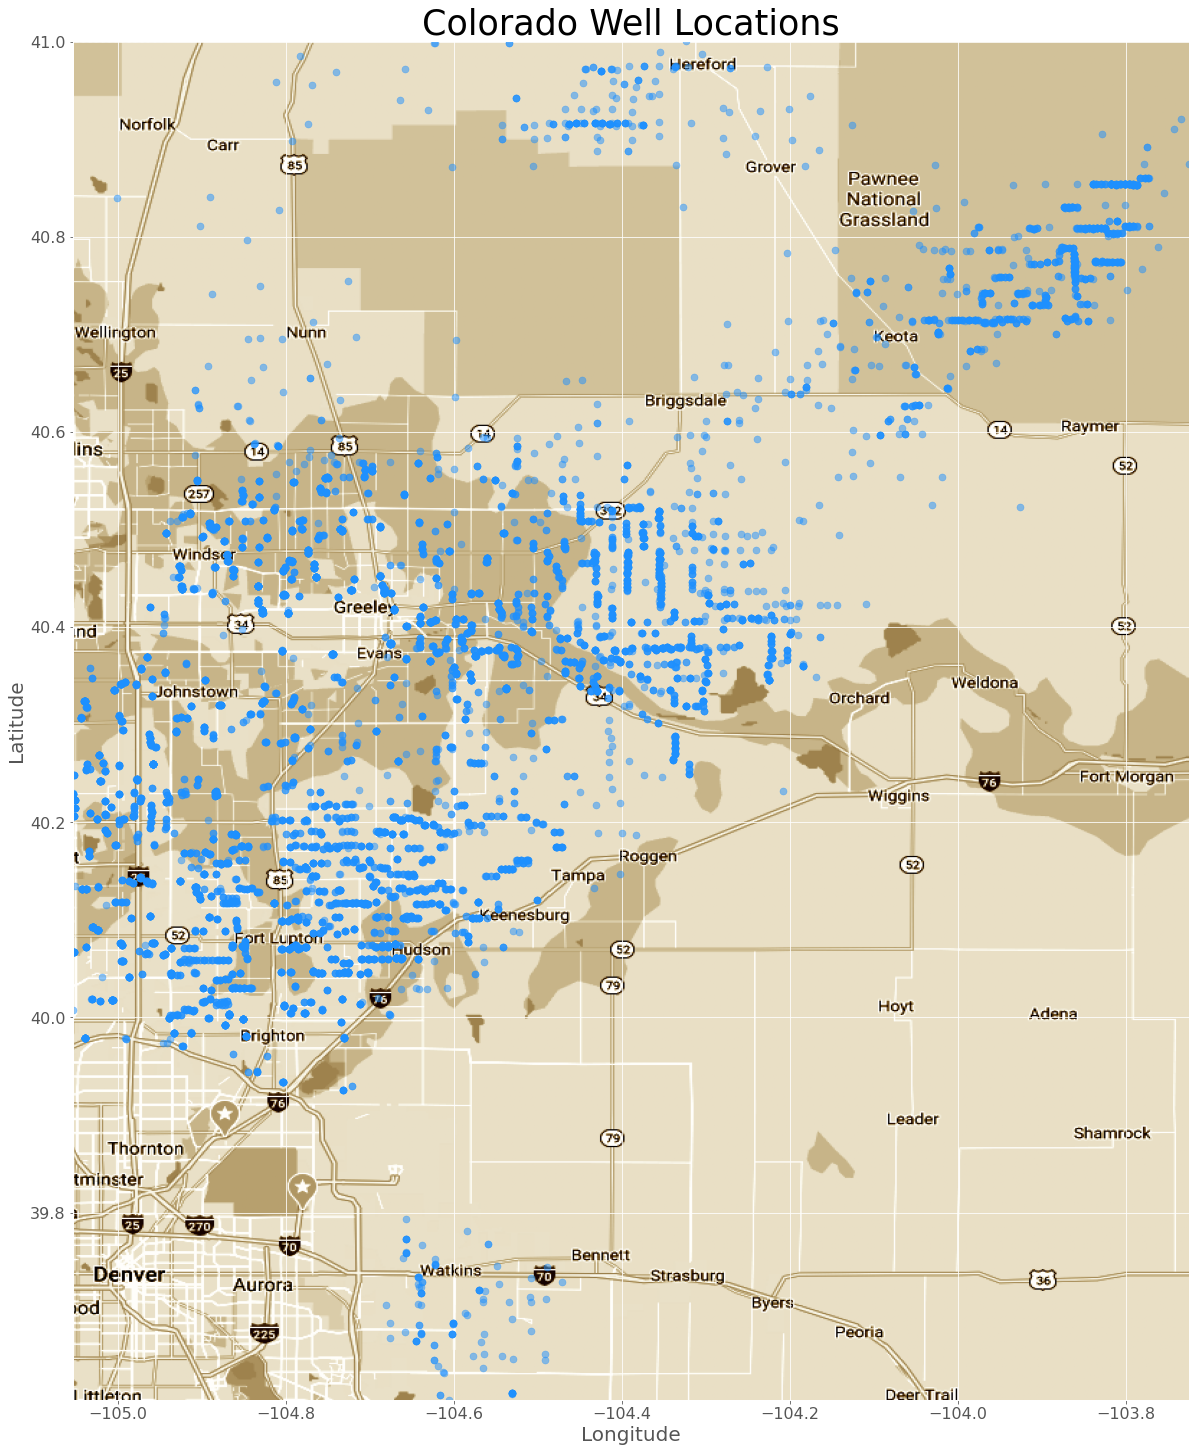

In [21]:
fig, ax = plt.subplots(figsize = (20, 25))

scatter_plt(ax, y_long, x_lat, 'Colorado Well Locations', 'Latitude', 'Longitude', 'dodgerblue', zorder=1)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlim(bbox[0], bbox[1])
ax.set_ylim(bbox[2], bbox[3])
ax.imshow(map_, zorder=0, extent = bbox, aspect='auto')

plt.savefig('./images/well_location.png')

In [22]:
fluid_df = spark.sql("""
                    SELECT
                        api,
                        State,
                        TotalCleanVol,
                        FluidVol1,
                        UPPER(FluidType1) AS fluid_type1,
                        FluidVol2,
                        UPPER(FluidType2) AS fluid_type2,
                        FluidVol3,
                        UPPER(FluidType3) AS fluid_type3,
                        FluidVol4,
                        UPPER(FluidType4) AS fluid_type4,
                        FluidVol5,
                        UPPER(FluidType5) AS fluid_type5
                    FROM data
                    WHERE State = 'COLORADO'
                    """)
# fluid_df.show()
# print(fluid_df.count())

In [23]:
fluid_df = drop_na_column(fluid_df, ["fluid_type1"])
wrong_fluid = ['HYBRID|X-LINK', 'X-LINK', 'ACID|OTHER FLUID', 'OTHER FLUID|WATER', 
               'HYBRID|LINEAR GEL', 'HYBRID|SLICKWATER', 'X-LINK|SLICKWATER', 'ACID|X-LINK', 'GEL|LINEAR GEL']
right_fluid = ['HYBRID', 'GEL', 'ACID', 'WATER', 'HYBRID', 'HYBRID', 'HYBRID', 'HYBRID', 'GEL']

fluid_df = fix_fluid_types(fluid_df, wrong_fluid, right_fluid)
fluid_df = fill_fluid_na(fluid_df)
    
fluid_df = drop_na_column(fluid_df, ["TotalCleanVol"])
fluid_df = fluid_df.distinct()

     df = df.withColumn('hybrid_collect', lit(0))
     df = df.withColumn('hybrid1', when(col('fluid_type1') == 'HYBRID', col('FluidVol1')).otherwise(0))
     df = df.withColumn('hybrid_collect', col('hybrid_collect') + col('hybrid1'))

In [25]:
fluid_df = clean_fluid_type(fluid_df, 'HYBRID')
# fluid_df.show()
fluid_df = clean_fluid_type(fluid_df, 'SLICKWATER')
# fluid_df.show()
fluid_df = clean_fluid_type(fluid_df, 'GEL')
# fluid_df.show()

columns_to_drop = ['hybrid1', 'hybrid2', 'hybrid3', 'hybrid4', 'hybrid5',
                   'slickwater1', 'slickwater2', 'slickwater3', 'slickwater4', 'slickwater5',
                   'gel1', 'gel2', 'gel3', 'gel4', 'gel5',
                   'FluidVol1', 'fluid_type1','FluidVol2','fluid_type2', 'FluidVol3', 
                   'fluid_type3', 'FluidVol4', 'fluid_type4', 'FluidVol5', 'fluid_type5']
fluid_df = fluid_df.drop(*columns_to_drop)

In [26]:
fluid_df.show(50)

+-------------+--------+-------------+--------------+------------------+-----------+
|          api|   State|TotalCleanVol|hybrid_collect|slickwater_collect|gel_collect|
+-------------+--------+-------------+--------------+------------------+-----------+
|5123450470000|COLORADO|        97227|             0|             91186|          0|
|5123320810100|COLORADO|        17045|             0|              2173|       9574|
|5123403830000|COLORADO|       146513|             0|             64588|          0|
|5123376830000|COLORADO|       102024|             0|            102024|          0|
|5123360060000|COLORADO|       184744|             0|            160288|      21992|
|5123377060000|COLORADO|        65210|             0|             65210|          0|
|5123377340000|COLORADO|        65892|             0|             22832|      43060|
|5123440840000|COLORADO|       127878|             0|             31866|      94333|
|5123453750000|COLORADO|       366038|             0|            

In [27]:
production_df = spark.sql("""
                    SELECT 
                        api,
                        State,
                        UPPER(formation) AS formation, 
                        Prod545DayOil AS day545
                    FROM data
                    WHERE state = "COLORADO"
                    """)
# production_df.show()

In [28]:
compare_df = fluid_df.join(production_df, ['api'], 'left_outer')
compare_df = drop_na_column(compare_df, ['day545'])
columns_to_drop = ['State', 'TotalCleanVol']
compare_df = compare_df.drop(*columns_to_drop)
compare_df.show()

+-------------+--------------+------------------+-----------+---------+------+
|          api|hybrid_collect|slickwater_collect|gel_collect|formation|day545|
+-------------+--------------+------------------+-----------+---------+------+
|5069064360000|         44806|                 0|          0| NIOBRARA|  7859|
|5123306860000|         64665|                 0|          0| NIOBRARA| 52972|
|5123312210000|             0|              2624|      33142| NIOBRARA| 16367|
|5123314470100|             0|                 0|     108719| NIOBRARA| 10260|
|5123323680000|             0|                 0|      52355| NIOBRARA| 36142|
|5123324860100|             0|                 0|      28173| NIOBRARA|  4204|
|5123324870100|         29544|                 0|          0| NIOBRARA|  5428|
|5123324890100|             0|                 0|      38309| NIOBRARA|  7447|
|5123325010000|             0|                 0|      72586| NIOBRARA| 30017|
|5123328120000|         56886|                 0|   

In [29]:
compare_df.createOrReplaceTempView("design_data")
slick_production_df = spark.sql("""
                    SELECT
                        api,
                        slickwater_collect,
                        day545
                    FROM design_data
                    WHERE slickwater_collect > 0
                    ORDER BY day545 DESC
                    """)
print(slick_production_df.count())

gel_production_df = spark.sql("""
                    SELECT
                        api,
                        gel_collect,
                        day545
                    FROM design_data
                    WHERE gel_collect > 0
                    ORDER BY day545 DESC
                    """)
print(gel_production_df.count())

hybrid_production_df = spark.sql("""
                    SELECT
                        api,
                        hybrid_collect,
                        day545
                    FROM design_data
                    WHERE hybrid_collect > 0
                    ORDER BY day545 DESC
                    """)
print(hybrid_production_df.count())

4293
3059
1167


In [30]:
slick_production = slick_production_df.rdd.map(lambda x: x.day545).collect()
gel_production = gel_production_df.rdd.map(lambda x: x.day545).collect()
hybrid_production = hybrid_production_df.rdd.map(lambda x: x.day545).collect()

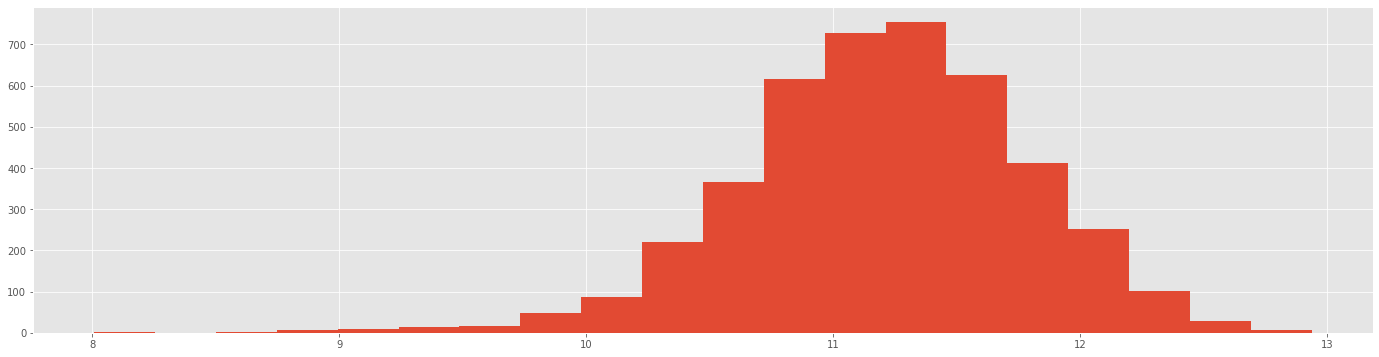

In [31]:
fig, ax = plt.subplots(figsize = (24, 6))

ax.hist(np.log(slick_production), bins=20, label='oil produced');

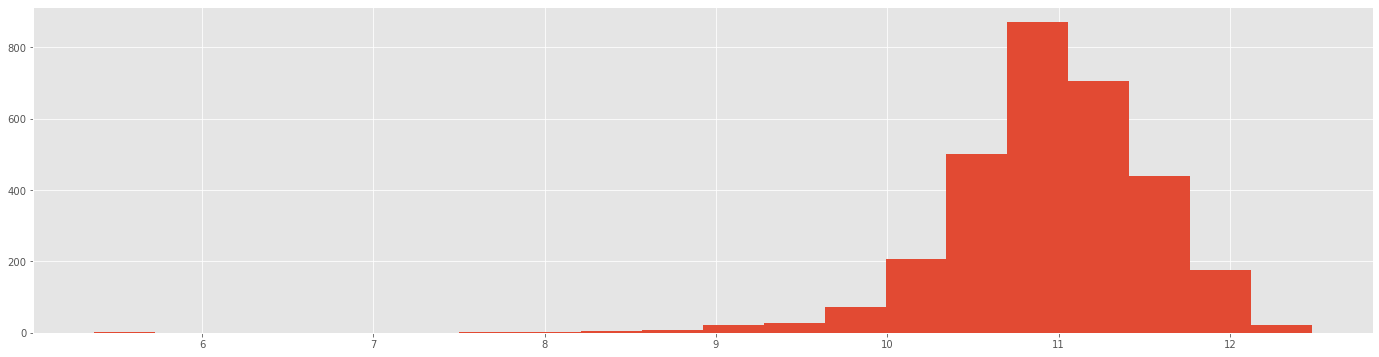

In [32]:
fig, ax = plt.subplots(figsize = (24, 6))

ax.hist(np.log(gel_production), bins=20, label='oil produced');

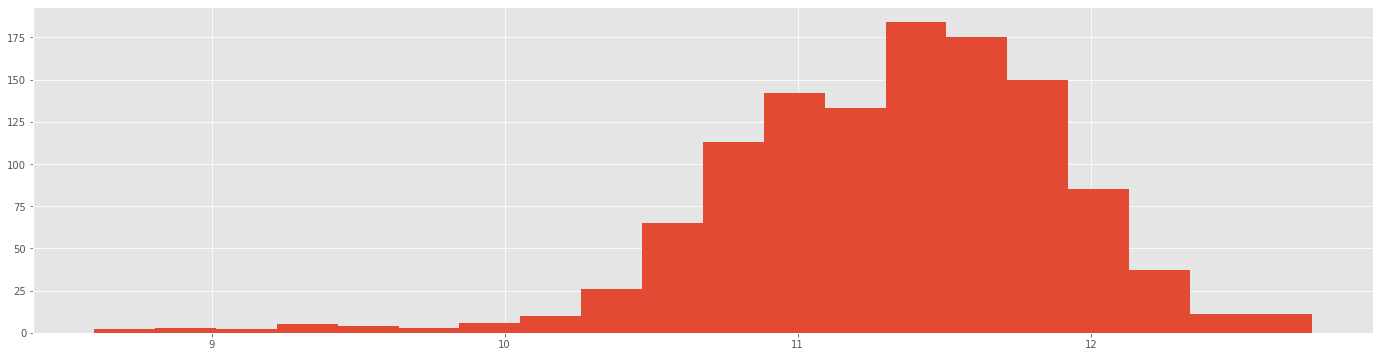

In [33]:
fig, ax = plt.subplots(figsize = (24, 6))
ax.hist(np.log(hybrid_production), bins=20, label='oil produced');

Ho: they produce the same.
Ha: they dont produce the same.

non parametric test - not assume distribution
mann-whitney u test (2 samples)
p-value: -prob under Ho the test stats, see more extreme
         -measure how likely the data smaple would be observed is the null hypothesis were true
         -probailbity of the data given the pre-specified assumption embedded in the statistical test.
         -AKA it's a "letter grade" for the Ho
markov chain
after 3

MANN-WHITNEY U TEST
-nonparametric equivalent of the two sample t-test
-makes no such assumption about the distribution
-The null hypothesis for the test is that the probability is 50% that a randomly drawn member of the first population 
 will exceed a member of the second population. An alternate null hypothesis is that the two samples come from the same population 
 (i.e. that they both have the same median).
 
-produce a U Statistic. 

-bonferoni correction for doing 3 tests


In [34]:
slick_wins = winner_counter(slick_production, gel_production)
gel_wins = winner_counter(gel_production, slick_production)
print("Number of Slick Wins: {}".format(slick_wins))
print("Number of Gel Wins: {}".format(gel_wins))

res = stats.mannwhitneyu(slick_production, gel_production, alternative="two-sided")
print("p-value for Slick = Gel: {}".format(res.pvalue))

Number of Slick Wins: 8154753.5
Number of Gel Wins: 4977533.5
p-value for Slick = Gel: 3.5445683029759616e-70


In [35]:
slick_wins = winner_counter(slick_production, hybrid_production)
hybrid_wins = winner_counter(hybrid_production, slick_production)
print("Number of Slick Wins: {}".format(slick_wins))
print("Number of hybrid Wins: {}".format(hybrid_wins))

res = stats.mannwhitneyu(slick_production, hybrid_production, alternative="two-sided")
print("p-value for Slick = Hybrid: {}".format(res.pvalue))

Number of Slick Wins: 2176643.0
Number of hybrid Wins: 2833288.0
p-value for Slick = Hybrid: 6.15374670613759e-12


In [36]:
gel_wins = winner_counter(gel_production, hybrid_production)
hybrid_wins = winner_counter(hybrid_production, gel_production)
print("Number of Gel Wins: {}".format(gel_wins))
print("Number of Hybrid Wins: {}".format(hybrid_wins))

res = stats.mannwhitneyu(gel_production, hybrid_production, alternative="two-sided")
print("p-value for Gel = Hybrid: {}".format(res.pvalue))

Number of Gel Wins: 1124037.5
Number of Hybrid Wins: 2445815.5
p-value for Gel = Hybrid: 1.6082501404922976e-77


The **Bonferroni Correction** is a popular way to rectify the over testing issue.

Suppose we want to test a combined hypothesis as a threshold of $\alpha$.  The bonferroni correction procedure then tests each of the individual hypothesies at a threshold of

$$ \alpha_\text{Bonferroni} = \frac{\alpha}{\text{# of Hypothesies in Combined Hypothesis}} $$

In [37]:
alpha = .01
hypo_combine = 3

In [38]:
alpha_b = alpha/hypo_combine
alpha_b

0.0033333333333333335

In [39]:
slick_prod_nio_df = spark.sql("""
                    SELECT
                        api,
                        slickwater_collect,
                        day545
                    FROM design_data
                    WHERE slickwater_collect > 0 AND formation = "NIOBRARA"
                    ORDER BY day545 DESC
                    """)

gel_prod_nio_df = spark.sql("""
                    SELECT
                        api,
                        slickwater_collect,
                        day545
                    FROM design_data
                    WHERE gel_collect > 0 AND formation = "NIOBRARA"
                    ORDER BY day545 DESC
                    """)

hybrid_prod_nio_df = spark.sql("""
                    SELECT
                        api,
                        slickwater_collect,
                        day545
                    FROM design_data
                    WHERE hybrid_collect > 0 AND formation = "NIOBRARA"
                    ORDER BY day545 DESC
                    """)


In [40]:
slick_prod_nio = slick_prod_nio_df.rdd.map(lambda x: x.day545).collect()
gel_prod_nio = gel_prod_nio_df.rdd.map(lambda x: x.day545).collect()
hybrid_prod_nio = hybrid_prod_nio_df.rdd.map(lambda x: x.day545).collect()

In [41]:
slick_wins = winner_counter(slick_prod_nio, gel_prod_nio)
gel_wins = winner_counter(gel_prod_nio, slick_prod_nio)
print("Number of Slick Wins: {}".format(slick_wins))
print("Number of Gel Wins: {}".format(gel_wins))

res = stats.mannwhitneyu(slick_prod_nio, gel_prod_nio, alternative="two-sided")
print("p-value for Slick = Gel: {}".format(res.pvalue))

Number of Slick Wins: 5034804.0
Number of Gel Wins: 3009388.0
p-value for Slick = Gel: 3.1229517112490374e-60


In [42]:
slick_wins = winner_counter(slick_prod_nio, hybrid_prod_nio)
hybrid_wins = winner_counter(hybrid_prod_nio, slick_prod_nio)
print("Number of Slick Wins: {}".format(slick_wins))
print("Number of hybrid Wins: {}".format(hybrid_wins))

res = stats.mannwhitneyu(slick_prod_nio, hybrid_prod_nio, alternative="two-sided")
print("p-value for Slick = Hybrid: {}".format(res.pvalue))

Number of Slick Wins: 1335229.0
Number of hybrid Wins: 1690859.0
p-value for Slick = Hybrid: 3.5501995603237904e-08


In [43]:
gel_wins = winner_counter(gel_prod_nio, hybrid_prod_nio)
hybrid_wins = winner_counter(hybrid_prod_nio, gel_prod_nio)
print("Number of Gel Wins: {}".format(gel_wins))
print("Number of Hybrid Wins: {}".format(hybrid_wins))

res = stats.mannwhitneyu(gel_prod_nio, hybrid_prod_nio, alternative="two-sided")
print("p-value for Gel = Hybrid: {}".format(res.pvalue))

Number of Gel Wins: 768681.0
Number of Hybrid Wins: 1650663.0
p-value for Gel = Hybrid: 4.789984413283054e-62


In [44]:
slick_prod_cod_df = spark.sql("""
                    SELECT
                        api,
                        slickwater_collect,
                        day545
                    FROM design_data
                    WHERE slickwater_collect > 0 AND formation = "CODELL"
                    ORDER BY day545 DESC
                    """)

gel_prod_cod_df = spark.sql("""
                    SELECT
                        api,
                        slickwater_collect,
                        day545
                    FROM design_data
                    WHERE gel_collect > 0 AND formation = "CODELL"
                    ORDER BY day545 DESC
                    """)

hybrid_prod_cod_df = spark.sql("""
                    SELECT
                        api,
                        slickwater_collect,
                        day545
                    FROM design_data
                    WHERE hybrid_collect > 0 AND formation = "CODELL"
                    ORDER BY day545 DESC
                    """)


In [45]:
slick_prod_cod = slick_prod_cod_df.rdd.map(lambda x: x.day545).collect()
gel_prod_cod = gel_prod_cod_df.rdd.map(lambda x: x.day545).collect()
hybrid_prod_cod = hybrid_prod_cod_df.rdd.map(lambda x: x.day545).collect()

In [46]:
slick_wins = winner_counter(slick_prod_cod, gel_prod_cod)
gel_wins = winner_counter(gel_prod_cod, slick_prod_cod)
print("Number of Slick Wins: {}".format(slick_wins))
print("Number of Gel Wins: {}".format(gel_wins))

res = stats.mannwhitneyu(slick_prod_cod, gel_prod_cod, alternative="two-sided")
print("p-value for Slick = Gel: {}".format(res.pvalue))

Number of Slick Wins: 347242.0
Number of Gel Wins: 228696.0
p-value for Slick = Gel: 2.1238885151123095e-11


In [47]:
slick_wins = winner_counter(slick_prod_cod, hybrid_prod_cod)
hybrid_wins = winner_counter(hybrid_prod_cod, slick_prod_cod)
print("Number of Slick Wins: {}".format(slick_wins))
print("Number of hybrid Wins: {}".format(hybrid_wins))

res = stats.mannwhitneyu(slick_prod_cod, hybrid_prod_cod, alternative="two-sided")
print("p-value for Slick = Hybrid: {}".format(res.pvalue))

Number of Slick Wins: 95360.5
Number of hybrid Wins: 139693.5
p-value for Slick = Hybrid: 1.3655356848899197e-05


In [48]:
gel_wins = winner_counter(gel_prod_cod, hybrid_prod_cod)
hybrid_wins = winner_counter(hybrid_prod_cod, gel_prod_cod)
print("Number of Gel Wins: {}".format(gel_wins))
print("Number of Hybrid Wins: {}".format(hybrid_wins))

res = stats.mannwhitneyu(gel_prod_cod, hybrid_prod_cod, alternative="two-sided")
print("p-value for Gel = Hybrid: {}".format(res.pvalue))

Number of Gel Wins: 32745.5
Number of Hybrid Wins: 76341.5
p-value for Gel = Hybrid: 2.5105789521437427e-17
